<a href="https://colab.research.google.com/github/RodrigoSousa0/project1-colab/blob/main/Project1_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Install Roboflow and Download Dataset


In [ ]:
!pip install roboflow keras_tuner gradio opencv-python

from roboflow import Roboflow
rf = Roboflow(api_key="8dRNgbX9N7gviFYrGUZ6")
project = rf.workspace("project-one-oamrm").project("project-one-2")
version = project.version(7)
dataset = version.download("folder")


loading Roboflow workspace...
loading Roboflow project...


# 2. Setup Paths and Imports


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64

base_dir = dataset.location
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "valid")
test_dir = os.path.join(base_dir, "test")

# Check if folders exist
print("Train dir:", train_dir)
print("Val dir:", val_dir)
print("Test dir:", test_dir)

Train dir: /content/Project-one-2-7/train
Val dir: /content/Project-one-2-7/valid
Test dir: /content/Project-one-2-7/test


# 3. Load the Data


In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = test_ds.class_names


Found 16230 files belonging to 3 classes.
Found 1517 files belonging to 3 classes.
Found 748 files belonging to 3 classes.


# 5. Preprocess with ResNet preprocessing

In [ ]:
from tensorflow.keras.applications.resnet import preprocess_input

train_ds = train_ds.map(lambda X, y: (preprocess_input(X), y))
val_ds = val_ds.map(lambda X, y: (preprocess_input(X), y))
test_ds = test_ds.map(lambda X, y: (preprocess_input(X), y))

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


# 6. Build model function for Keras Tuner (Hyperparameter tuning)

In [ ]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras import layers, models, optimizers, losses, metrics

def build_model(hp):
    base = ResNet101(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
    base.trainable = False
    inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(3, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    hp_learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    hp_optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    if hp_optimizer == 'adam':
        optimizer = optimizers.Adam(learning_rate=hp_learning_rate)
    else:
        optimizer = optimizers.SGD(learning_rate=hp_learning_rate, momentum=0.9)
    model.compile(
        optimizer=optimizer,
        loss=losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[metrics.SparseCategoricalAccuracy(name="accuracy")]
    )
    return model

# 7. Hyperparameter search using Keras Tuner

In [ ]:
import keras_tuner as kt

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    overwrite=True,
    directory='hyperparam_tuning',
    project_name='resnet101_tuning'
)

tuner.search(train_ds, validation_data=val_ds, epochs=10, verbose=2)

best_hps = tuner.get_best_hyperparameters(1)[0]
print(f"Best learning rate: {best_hps.get('learning_rate')}")
print(f"Best optimizer: {best_hps.get('optimizer')}")


Trial 6 Complete [00h 01m 02s]
val_accuracy: 0.9604482650756836

Best val_accuracy So Far: 0.9604482650756836
Total elapsed time: 00h 06m 20s
Best learning rate: 0.01
Best optimizer: adam


# 8. Build and compile final model with best hyperparameters

In [ ]:
if best_hps.get('optimizer') == 'adam':
    optimizer = optimizers.Adam(learning_rate=best_hps.get('learning_rate'))
else:
    optimizer = optimizers.SGD(learning_rate=best_hps.get('learning_rate'), momentum=0.9)

base_model = ResNet101(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(3, activation='softmax')(x)
model = models.Model(inputs, outputs)

model.compile(optimizer=optimizer,
              loss=losses.SparseCategoricalCrossentropy(),
              metrics=[metrics.SparseCategoricalAccuracy(name="accuracy")])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet101 (Functional)          │ (None, 7, 7, 2048)     │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         6,147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,664,323 (162.75 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 42,658,176 (162.73 MB)

# 9. Train the model with EarlyStopping and ModelCheckpoint

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_cb = ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
earlystop_cb = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, mode='max', verbose=1)

epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 1/30
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7493 - loss: 0.5198
Epoch 1: val_accuracy improved from -inf to 0.91430, saving model to best_model.keras
508/508 ━━━━━━━━━━━━━━━━━━━━ 47s 59ms/step - accuracy: 0.7495 - loss: 0.5195 - val_accuracy: 0.9143 - val_loss: 0.1943
Epoch 2/30
507/508 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8849 - loss: 0.2540
Epoch 2: val_accuracy improved from 0.91430 to 0.95386, saving model to best_model.keras
508/508 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.8849 - loss: 0.2540 - val_accuracy: 0.9539 - val_loss: 0.1368
Epoch 3/30
507/508 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8980 - loss: 0.2302
Epoch 3: val_accuracy improved from 0.95386 to 0.96111, saving model to best_model.keras
508/508 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.8980 - loss: 0.2302 - val_accuracy: 0.9611 - val_loss: 0.1043
Epoch 4/30
507/508 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9104 - loss: 0.2095
Epoch 4: val_accuracy did not i

# 10. Evaluate on the test set and get predictions for report/confusion matrix

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

model = tf.keras.models.load_model("best_model.keras")

y_true = []
y_pred = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Class names:", class_names)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


Class names: ['away-from-desk', 'distracted', 'studying']

Classification Report:
                precision    recall  f1-score   support

away-from-desk       1.00      1.00      1.00       255
    distracted       0.97      0.96      0.96       247
      studying       0.96      0.97      0.96       246

      accuracy                           0.97       748
     macro avg       0.97      0.97      0.97       748
  weighted avg       0.97      0.97      0.97       748

Confusion Matrix:
 [[255   0   0]
 [  0 236  11]
 [  0   8 238]]


# 11. Plot the confusion matrix

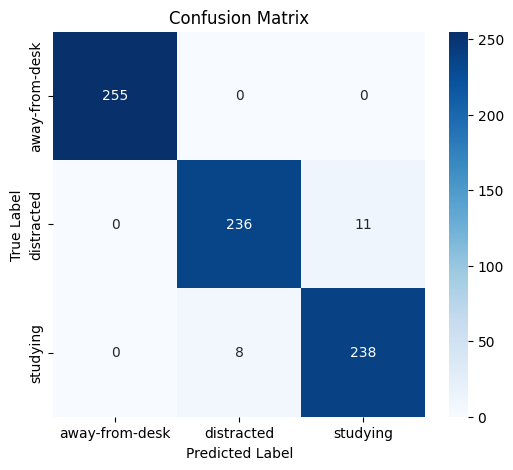

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# 12. Save the trained model to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model_save_path = "/content/drive/MyDrive/model_v1_resnet101.keras"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to /content/drive/MyDrive/model_v1_resnet101.keras


Gradio Interface

In [ ]:
import os
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
import pandas as pd
import cv2

from tensorflow.keras.applications.resnet import preprocess_input

# Path to your model
MODEL_PATH = "/content/drive/MyDrive/model-v1.h5"
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model file not found at {MODEL_PATH}.")
model = tf.keras.models.load_model(MODEL_PATH)

class_names = ['away-from-desk', 'distracted', 'studying']

def preprocess_image(img):
    """Resize to 224x224, convert to RGB, preprocess for ResNet, return model_input and display_img."""
    if isinstance(img, np.ndarray):
        img = Image.fromarray(img)
    img = img.convert("RGB")
    img_resized = img.resize((224, 224))
    img_array = np.array(img_resized, dtype=np.float32)
    # ResNet preprocessing: RGB->BGR, zero-centered with mean subtraction
    img_preprocessed = preprocess_input(img_array.copy())  # .copy() for safety
    model_input = np.expand_dims(img_preprocessed, axis=0)
    # For display: just show resized, not preprocessed
    return model_input, img_resized

def classify_image(image):
    if image is None:
        raise gr.Error("No image provided.")
    input_tensor, display_img = preprocess_image(image)
    preds = model.predict(input_tensor)[0]
    probs_dict = {class_names[i]: float(preds[i]) for i in range(len(class_names))}
    return probs_dict, display_img

def classify_video(video_path):
    if video_path is None:
        raise gr.Error("No video provided.")
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise gr.Error("Failed to open video.")
    fps = cap.get(cv2.CAP_PROP_FPS) or 1
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps
    num_seconds = max(1, int(duration))
    results = []
    for sec in range(num_seconds):
        cap.set(cv2.CAP_PROP_POS_MSEC, sec * 1000)
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(frame_rgb).resize((224, 224))
        img_array = np.array(pil_img, dtype=np.float32)
        input_tensor = np.expand_dims(preprocess_input(img_array), axis=0)
        preds = model.predict(input_tensor)[0]
        result_row = {"time(sec)": sec}
        for i, cls in enumerate(class_names):
            result_row[cls] = float(preds[i])
        results.append(result_row)
    cap.release()
    if not results:
        raise gr.Error("No frames were extracted from the video.")
    df = pd.DataFrame(results)
    return df

with gr.Blocks(title="Student Activity Classification") as demo:
    gr.Markdown("# Student Activity Classifier")
    gr.Markdown("Upload an image/video or use webcam. See the preprocessed (resized) image and class probabilities.")

    with gr.Tabs():
        with gr.Tab("Image"):
            image_input = gr.Image(type="pil", label="Upload Image")
            img_predict_btn = gr.Button("Classify Image")
            img_output = gr.Label(label="Predicted Probabilities")
            img_pre_out = gr.Image(label="Preprocessed (Resized) Image for Model")
            img_predict_btn.click(
                fn=classify_image,
                inputs=image_input,
                outputs=[img_output, img_pre_out]
            )
        with gr.Tab("Video"):
            video_input = gr.Video(label="Upload Video (.mp4, .webm, etc.)")
            vid_predict_btn = gr.Button("Analyze Video")
            vid_output = gr.Dataframe(label="Frame-by-Frame Predictions", headers=["time(sec)"] + class_names)
            vid_predict_btn.click(
                fn=classify_video,
                inputs=video_input,
                outputs=vid_output
            )
        with gr.Tab("Webcam"):
            webcam_input = gr.Image(type="pil", label="Webcam Snapshot")
            cam_predict_btn = gr.Button("Classify Image")
            cam_output = gr.Label(label="Predicted Probabilities")
            cam_pre_out = gr.Image(label="Preprocessed (Resized) Image for Model")
            cam_predict_btn.click(
                fn=classify_image,
                inputs=webcam_input,
                outputs=[cam_output, cam_pre_out]
            )

demo.launch(share=True)


TypeError: Image.__init__() got an unexpected keyword argument 'webcam'

In [ ]:
import gradio as gr
print(gr.__version__)


5.32.1
